### IMPORTS

In [1]:
import matplotlib.pyplot as plt
from astropy.stats import median_absolute_deviation
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict
color = sns.color_palette()
from string import ascii_uppercase
from datetime import timedelta
import pprint
import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# Auto reload custom modules

pd.set_option('display.mpl_style', 'default')
%matplotlib inline

### load data

In [3]:
logdf = pd.read_csv(os.getcwd()+'/data/2015_07_22_mktplace_shop_web_log_sample.log',
                    delim_whitespace=True, error_bad_lines=False, header=None)

b'Skipping line 491258: expected 15 fields, saw 16\nSkipping line 491610: expected 15 fields, saw 16\nSkipping line 491949: expected 15 fields, saw 16\nSkipping line 492270: expected 15 fields, saw 16\nSkipping line 492551: expected 15 fields, saw 16\nSkipping line 492802: expected 15 fields, saw 16\nSkipping line 493232: expected 15 fields, saw 16\nSkipping line 496262: expected 15 fields, saw 16\nSkipping line 496279: expected 15 fields, saw 16\nSkipping line 496682: expected 15 fields, saw 16\nSkipping line 496709: expected 15 fields, saw 16\nSkipping line 496965: expected 15 fields, saw 16\nSkipping line 497004: expected 15 fields, saw 16\nSkipping line 497230: expected 15 fields, saw 16\nSkipping line 497257: expected 15 fields, saw 16\nSkipping line 497726: expected 15 fields, saw 16\nSkipping line 497767: expected 15 fields, saw 16\nSkipping line 497964: expected 15 fields, saw 16\nSkipping line 497987: expected 15 fields, saw 16\n'
b'Skipping line 547659: expected 15 fields, sa

In [4]:
# skipped  = [491258, 491610, 491949, 492270,491551, 492802, 493232, 496262, 496279, 496682,496709, 496965, 497004, 
# 497230, 497257, 497726, 497767, 497964, 497987, 547659, 553004, 565091]

In [5]:
mystr = 'timestamp elb \
    client_port \
    backend_port \
    request_processing_time \
    backend_processing_time \
    response_processing_time \
    elb_status_code \
    backend_status_code \
    received_bytes \
    sent_bytes \
    request \
    user_agent \
    ssl_cipher \
    ssl_protocol'


In [6]:
wordList = re.sub("[^\w]", " ",  mystr).split()

In [7]:
wordList

['timestamp',
 'elb',
 'client_port',
 'backend_port',
 'request_processing_time',
 'backend_processing_time',
 'response_processing_time',
 'elb_status_code',
 'backend_status_code',
 'received_bytes',
 'sent_bytes',
 'request',
 'user_agent',
 'ssl_cipher',
 'ssl_protocol']

In [8]:
logdf.columns = wordList

In [9]:
logdf['client_IP'] = logdf['client_port'].apply(lambda x: x.split(':')[0])
logdf['count_IP'] = logdf.groupby('client_IP')['client_IP'].transform('count')
logdf['timestamp'] = pd.to_datetime(logdf['timestamp'], errors='coerce')
logdf.sort_values(by=['client_IP','timestamp'], ascending=True, inplace=True)
logdf['new_id'] = logdf.groupby(logdf.client_IP).ngroup() + 1

In [10]:
logdf["url"] = logdf["request"].str.split(" ", expand=True)[1]

In [11]:
logdf['count_client_port'] = logdf.groupby(['client_port'])['client_port'].transform('count')

In [12]:
unique_ports = logdf.groupby('client_IP')['count_client_port'].nunique()

In [13]:
logdf = logdf.merge(pd.DataFrame(unique_ports).reset_index(drop=False), on='client_IP')

In [15]:
logdf.columns

Index(['timestamp', 'elb', 'client_port', 'backend_port',
       'request_processing_time', 'backend_processing_time',
       'response_processing_time', 'elb_status_code', 'backend_status_code',
       'received_bytes', 'sent_bytes', 'request', 'user_agent', 'ssl_cipher',
       'ssl_protocol', 'client_IP', 'count_IP', 'new_id', 'url',
       'count_client_port_x', 'count_client_port_y'],
      dtype='object')

In [17]:
logdf.columns = ['timestamp', 'elb', 'client_port', 'backend_port',
       'request_processing_time', 'backend_processing_time',
       'response_processing_time', 'elb_status_code', 'backend_status_code',
       'received_bytes', 'sent_bytes', 'request', 'user_agent', 'ssl_cipher',
       'ssl_protocol', 'client_IP', 'count_IP', 'new_id','url',
       'count_client_port', 'unique_port_count']

#### Sessionize the web log

In [18]:
logdf["prev_timestamp"] = logdf[['client_IP', 'timestamp']].groupby('client_IP').transform(lambda x:x.shift(1))
inactive_window = timedelta(seconds=10*60)
logdf['next_session'] = ((logdf['timestamp'] - logdf['prev_timestamp']) >= inactive_window).astype(int)
logdf['session'] = logdf.groupby("client_IP")['next_session'].cumsum()
logdf['session_id'] = logdf["client_IP"].str.cat(logdf["session"].astype(str), sep='_')

In [19]:
session_length = (logdf[['session_id', 'timestamp']].groupby('session_id')
                                                        .agg({'timestamp': [(
                                                            'session_length', lambda x: np.ptp(
                                                                x).seconds)]}))

session_length.columns = session_length.columns.droplevel()
session_length.reset_index(drop=False, inplace=True)

In [20]:
#session_length
session_length["client_IP"], session_length["session"] = session_length["session_id"].str.split("_").str
session_length["session"] = session_length["session"].astype(int)

#### Average session time 


In [21]:
se_avg_len = round(session_length[session_length['session_length'] != 0]['session_length'].mean(),2)
print ("Removing sessions_id with zero session_time, average session_time :", se_avg_len)

Removing sessions_id with zero session_time, average session_time : 102.13


In [22]:
print ('Per session :' , round(se_avg_len/60,3), 'minutes')

Per session : 1.702 minutes


#### Unique URL counts

In [23]:
url_count_data = (logdf[['session_id', 'url']].groupby('session_id')
                                             .agg({'url': [('unique_url_count', lambda x: x.nunique())]}))

url_count_data.columns = url_count_data.columns.droplevel()

url_count_data.reset_index(drop=False, inplace=True)

url_count_data.head(10)

,session_id,unique_url_count
0,1.186.101.79_0,9
1,1.186.101.79_1,8
2,1.186.103.240_0,5
3,1.186.103.78_0,4
4,1.186.108.213_0,2
5,1.186.108.230_0,5
6,1.186.108.242_0,3
7,1.186.108.28_0,80
8,1.186.108.29_0,3
9,1.186.108.79_0,3


#### Most engaged user

#### Top 10 IPs with port number with maximum session length

In [24]:
ip_data = (session_length.groupby('client_IP')['session_length'].agg([('average_session_length', np.mean),
                                                                           ('number_of_sessions', 'count')])
                                                                     .reset_index()
                                                                     .sort_values('average_session_length', ascending=False))
n = 10 # To get top 100 most engaged users
top_n_users = ip_data.iloc[:n]

top_n_users.head(10)

,client_IP,average_session_length,number_of_sessions
63380,182.66.36.72,1162.0,1
80830,49.202.59.215,1157.0,1
86475,59.91.249.99,1141.0,1
61722,180.215.72.113,1139.0,1
88696,61.8.146.66,1139.0,1
1417,1.23.30.226,1134.0,1
87848,60.254.126.213,1134.0,1
32658,117.203.81.246,1130.0,1
21792,112.79.36.86,1129.0,1
53562,125.22.34.83,1129.0,1


#### Predict the expected load (requests/second) in the next minute

In [25]:
# logdf.to_csv('/home/xflow/Downloads/DataFiles/logdf.csv')

In [26]:
pred1_data = logdf.set_index("timestamp").resample("T").agg({'elb': [('Load', lambda x: np.count_nonzero(x)/60)],
                        'sent_bytes': [('sent_bytes_mean', lambda x: x.astype(float).mean())],
                        'received_bytes': [('received_bytes_mean', lambda x: x.astype(float).mean())],
                        'session_id': [('sessions_active', lambda x: x.nunique())],
                        'request_processing_time': [('request_processing_time_mean',
                                                     lambda x: x.astype(float).mean())],
                        'backend_processing_time': [('backend_processing_time_mean',
                                                     lambda x: x.astype(float).mean())],
                        'response_processing_time': [('response_processing_time_mean', 
                                                      lambda x: x.astype(float).mean())]})


In [27]:
pred1_data.columns = pred1_data.columns.droplevel()

In [28]:
prev_df = pred1_data.shift(1)

lag_cols = ['Load', 'sent_bytes_mean', 'received_bytes_mean',
       'sessions_active', 'request_processing_time_mean',
       'backend_processing_time_mean', 'response_processing_time_mean']

prev_df.columns = ["Prev_" + col for col in lag_cols]

In [29]:
load_data = pd.concat((pred1_data, prev_df), axis=1).fillna(0)
load_data["Minute"] = load_data.index.minute

In [30]:
final_pred_df = load_data[1:]
final_pred_df['Time'] = final_pred_df.index
cols_for_model = np.setdiff1d(final_pred_df.columns, ["Time", "Load"])

In [31]:
cols_for_model

array(['Minute', 'Prev_Load', 'Prev_backend_processing_time_mean',
       'Prev_received_bytes_mean', 'Prev_request_processing_time_mean',
       'Prev_response_processing_time_mean', 'Prev_sent_bytes_mean',
       'Prev_sessions_active', 'backend_processing_time_mean',
       'received_bytes_mean', 'request_processing_time_mean',
       'response_processing_time_mean', 'sent_bytes_mean',
       'sessions_active'], dtype=object)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
train, test, y_train, y_test = train_test_split(final_pred_df, final_pred_df["Load"], test_size=0.2, random_state=2018, shuffle=False)
build, val, y_build, y_val = train_test_split(train, y_train, test_size=0.25, random_state=2018, shuffle=False)
print(f" Build data shape: {build.shape}, Validation data shape: {val.shape} and Testing data shape: {test.shape}")

 Build data shape: (666, 16), Validation data shape: (222, 16) and Testing data shape: (222, 16)


In [34]:
rf = XGBRegressor(n_estimators=300, random_state=42)
rf.fit(build[cols_for_model], y_build)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
val_preds = rf.predict(val[cols_for_model])
test_preds = rf.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(y_val, val_preds)**0.5}")
print(f"Test RMSE: {mean_squared_error(y_test, test_preds)**0.5}")

Validation RMSE: 9.61811059652221
Test RMSE: 14.376918152716732


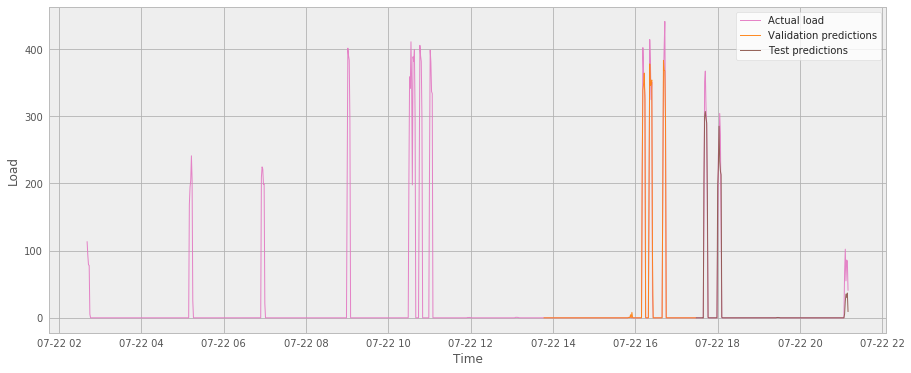

In [36]:
plt.figure(figsize=(15,6))
plt.xlabel('Time')
plt.ylabel('Load')
plt.plot(final_pred_df[["Time", "Load"]].set_index("Time"),color=color[6], alpha=0.9, label="Actual load")
plt.plot(pd.concat((val["Time"].reset_index(drop=True), pd.Series(val_preds, name="Load")), axis=1).set_index(
    "Time"),color=color[1], alpha=0.9, label="Validation predictions")

plt.plot(pd.concat((test["Time"].reset_index(drop=True), pd.Series(
    test_preds, name="Load")), axis=1).set_index(
    "Time"), color=color[5], alpha=0.9, label="Test predictions")

sns.set_style("whitegrid", {'axes.grid' : False})

plt.legend()


### 2.  Predict the session length for a given IP

In [37]:
data_df = logdf.copy(deep=True)
cols = ["sent_bytes", "received_bytes", "response_processing_time"]
data_df[cols] = data_df[cols].astype(np.float)
data_df["Device"] = data_df["user_agent"].str.contains("Mobile").replace({False: "Web", True: "Mobile"})
data_df["request_method"] = data_df["request"].str.split(" ", expand=True)[0]

In [38]:
device_data = (data_df[["session_id", "Device"]].pivot_table(index="session_id", 
                                                    columns=["Device"], 
                                                    aggfunc=np.count_nonzero)
                                                .reset_index().rename_axis(None, axis=1).fillna(0))
session_details = data_df[["session_id"]+cols].pivot_table(index="session_id", values=cols).reset_index()

In [39]:
lag_cols = ["Mobile", "Web", "DELETE", "GET", "HEAD", "OPTIONS", "POST", "PUT", 
            "received_bytes", "response_processing_time", "sent_bytes",
            "session_length", "unique_url_count"]

lag_cols = ["Mobile", "Web",
            "received_bytes", "response_processing_time", "sent_bytes",
            "session_length", "unique_url_count"]

tmp_0 = (pd.merge(session_length, url_count_data , how='left', on='session_id')
           .merge(device_data, on="session_id", how='left')
           .merge(session_details, on="session_id", how='left'))

tmp_1 = tmp_0.groupby("client_IP")[lag_cols].transform(lambda x: x.shift(1)).rename(columns=dict(zip(lag_cols, ["Prev_"+col for col in lag_cols])))
session_data = pd.concat((tmp_0.drop(np.setdiff1d(lag_cols, ["session_length", "unique_url_count"]), axis=1), 
                          tmp_1), axis=1)

In [50]:
session_data.head()

,session_id,session_length,client_IP,session,unique_url_count,Prev_Mobile,Prev_Web,Prev_received_bytes,Prev_response_processing_time,Prev_sent_bytes,Prev_session_length,Prev_unique_url_count
0,1.186.101.79_0,146,1.186.101.79,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.186.101.79_1,229,1.186.101.79,1,8,0.0,38.0,83.105263,0.000021,2168.789474,146.0,9.0
2,1.186.103.240_0,11,1.186.103.240,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.186.103.78_0,9,1.186.103.78,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.186.108.213_0,112,1.186.108.213,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Data is split based on session
# First 5 sessions in train
build = session_data[session_data["session"] < 6].fillna(0)
val = session_data[session_data["session"] == 6].fillna(0)
test = session_data[session_data["session"] > 6].fillna(0)

In [52]:
cols_for_model = ['Prev_Mobile', 'Prev_Web',
                   'Prev_received_bytes', 'Prev_response_processing_time',
                   'Prev_sent_bytes', 'Prev_session_length', 'Prev_unique_url_count']

In [53]:
rf_session_length = RandomForestRegressor(n_estimators=400, n_jobs=4, random_state=2018)
rf_session_length.fit(build[cols_for_model], np.log1p(build["session_length"]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [54]:
val_session_length_preds = rf_session_length.predict(val[cols_for_model])
test_session_length_preds = rf_session_length.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(val['session_length'], np.expm1(val_session_length_preds))**0.5}")
print(f"Test RMSE: {mean_squared_error(test['session_length'], np.expm1(test_session_length_preds))**0.5}")

Validation RMSE: 261.9237927281019
Test RMSE: 157.1270204044662


####  Predict the number of unique URL visits by a given IP

In [55]:
rf_url_count = RandomForestRegressor(n_estimators=500, n_jobs=4, random_state=2018)
rf_url_count.fit(build[cols_for_model], build["unique_url_count"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [56]:
val_url_count_preds = rf_url_count.predict(val[cols_for_model])
test_url_count_preds = rf_url_count.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(val['unique_url_count'], val_url_count_preds)**0.5}")
print(f"Test RMSE: {mean_squared_error(test['unique_url_count'], test_url_count_preds)**0.5}")

Validation RMSE: 463.870210859012
Test RMSE: 273.45773808923303


Field	Description
timestamp

The time when the load balancer received the request from the client, in ISO 8601 format.

elb

The name of the load balancer

client:port

The IP address and port of the requesting client.

backend:port

The IP address and port of the registered instance that processed this request.

If the load balancer can't send the request to a registered instance, or if the instance closes the connection before a response can be sent, this value is set to -.

This value can also be set to - if the registered instance does not respond before the idle timeout.

request_processing_time

[HTTP listener] The total time elapsed, in seconds, from the time the load balancer received the request until the time it sent it to a registered instance.

[TCP listener] The total time elapsed, in seconds, from the time the load balancer accepted a TCP/SSL connection from a client to the time the load balancer sends the first byte of data to a registered instance.

This value is set to -1 if the load balancer can't dispatch the request to a registered instance. This can happen if the registered instance closes the connection before the idle timeout or if the client sends a malformed request. Additionally, for TCP listeners, this can happen if the client establishes a connection with the load balancer but does not send any data.

This value can also be set to -1 if the registered instance does not respond before the idle timeout.

backend_processing_time

[HTTP listener] The total time elapsed, in seconds, from the time the load balancer sent the request to a registered instance until the instance started to send the response headers.

[TCP listener] The total time elapsed, in seconds, for the load balancer to successfully establish a connection to a registered instance.

This value is set to -1 if the load balancer can't dispatch the request to a registered instance. This can happen if the registered instance closes the connection before the idle timeout or if the client sends a malformed request.

This value can also be set to -1 if the registered instance does not respond before the idle timeout.

response_processing_time

[HTTP listener] The total time elapsed (in seconds) from the time the load balancer received the response header from the registered instance until it started to send the response to the client. This includes both the queuing time at the load balancer and the connection acquisition time from the load balancer to the client.

[TCP listener] The total time elapsed, in seconds, from the time the load balancer received the first byte from the registered instance until it started to send the response to the client.

This value is set to -1 if the load balancer can't dispatch the request to a registered instance. This can happen if the registered instance closes the connection before the idle timeout or if the client sends a malformed request.

This value can also be set to -1 if the registered instance does not respond before the idle timeout.

elb_status_code

[HTTP listener] The status code of the response from the load balancer.

backend_status_code

[HTTP listener] The status code of the response from the registered instance.

received_bytes

The size of the request, in bytes, received from the client (requester).

[HTTP listener] The value includes the request body but not the headers.

[TCP listener] The value includes the request body and the headers.

sent_bytes

The size of the response, in bytes, sent to the client (requester).

[HTTP listener] The value includes the response body but not the headers.

[TCP listener] The value includes the request body and the headers.

request

The request line from the client enclosed in double quotes and logged in the following format: HTTP Method + Protocol://Host header:port + Path + HTTP version.

[TCP listener] The URL is three dashes, each separated by a space, and ending with a space ("- - - ").

user_agent

[HTTP/HTTPS listener] A User-Agent string that identifies the client that originated the request. The string consists of one or more product identifiers, product[/version]. If the string is longer than 8 KB, it is truncated.

ssl_cipher

[HTTPS/SSL listener] The SSL cipher. This value is recorded only if the incoming SSL/TLS connection was established after a successful negotiation. Otherwise, the value is set to -.

ssl_protocol

[HTTPS/SSL listener] The SSL protocol. This value is recorded only if the incoming SSL/TLS connection was established after a successful negotiation. Otherwise, the value is set to -.